# Exercise 1
#### Count the number of lines in Python for each file

In [170]:
# Define path to CSV files
bookings_file = "/Users/je637620/Desktop/challenge/bookings.csv"
searches_file = "/Users/je637620/Desktop/challenge/searches.csv"

In [171]:
# Using Python
def number_of_lines(filename):
    nlines = 0
    with open(filename, "r") as f:
        while f.readline() != "":
            nlines += 1
    return nlines

print(f"Bookings file: {number_of_lines(bookings_file)} lines")
print(f"Searches file: {number_of_lines(searches_file)} lines")

Bookings file: 10000011 lines
Searches file: 20390199 lines


In [172]:
# Using Shell
!wc -l {bookings_file}
!wc -l {searches_file}

 10000011 /Users/je637620/Desktop/challenge/bookings.csv
 20390198 /Users/je637620/Desktop/challenge/searches.csv


# Exercise 2
#### Top 10 arrival airports in the world in 2013 (using the bookings file)

In [173]:
# Define path to CSV files
bookings_file = "/Users/je637620/Desktop/challenge/bookings.csv"

In [174]:
# Import required modules
import pandas as pd

In [175]:
# Inspect data in one chunk
pd.set_option("display.max_columns", None)
df = pd.read_csv(bookings_file, sep="^",  iterator=True, chunksize=10000)
for chunk in df:
    print(chunk.columns.to_list())
    print(chunk.dtypes)
    break

['act_date           ', 'source', 'pos_ctry', 'pos_iata', 'pos_oid  ', 'rloc          ', 'cre_date           ', 'duration', 'distance', 'dep_port', 'dep_city', 'dep_ctry', 'arr_port', 'arr_city', 'arr_ctry', 'lst_port', 'lst_city', 'lst_ctry', 'brd_port', 'brd_city', 'brd_ctry', 'off_port', 'off_city', 'off_ctry', 'mkt_port', 'mkt_city', 'mkt_ctry', 'intl', 'route          ', 'carrier', 'bkg_class', 'cab_class', 'brd_time           ', 'off_time           ', 'pax', 'year', 'month', 'oid      ']
act_date               object
source                 object
pos_ctry               object
pos_iata               object
pos_oid                object
rloc                   object
cre_date               object
duration                int64
distance                int64
dep_port               object
dep_city               object
dep_ctry               object
arr_port               object
arr_city               object
arr_ctry               object
lst_port               object
lst_city             

In [176]:
# Inspect data broadly
df = pd.read_csv(bookings_file, sep="^", usecols=["pax"],  iterator=True, chunksize=10000)
for chunk in df:
    if not chunk["pax"].dtypes in ["int64", "float64"]:
        print(chunk["pax"].dtype)

In [177]:
# Functions
def normalize_number(element):
        try:
            return int(element)
        except Exception as e:
            return 0

In [178]:
# read csv file using chunks. Restrict to columns of interest
df = pd.read_csv(bookings_file, sep="^", usecols=["arr_port", "pax", "year"],  iterator=True, chunksize=10000)

# created to control number of chunks to process for debugging
current_chunk = 1
max_chunks = -1

# Dataframes to concat partial results
arr_port_paxs_total = None
    
# Iterate every chunk
for chunk in df:

    # Clean data filling nan with 0 and removing null values on top
    chunk["pax"] = chunk["pax"].fillna(0)
    chunk = chunk[(chunk["arr_port"].notnull()) & (chunk["year"].notnull()) & (chunk["pax"].notnull())]
    
    # Filter data to year of interest
    chunk = chunk[chunk["year"] == 2013]
        
    # Normalize arr_port codes and pax numbers
    chunk["arr_port"] = chunk["arr_port"].str.strip().str.upper()
    chunk["pax"] = chunk["pax"].apply(normalize_number)
    
    # Group pax by arr_port (sum)
    arr_port_paxs = chunk.groupby(by="arr_port")["pax"].sum()
    
    # Append partial results to totals
    arr_port_paxs_total = pd.concat([arr_port_paxs_total, arr_port_paxs])
    
    if current_chunk > 0 and current_chunk == max_chunks:
        break
    current_chunk += 1

# Group by arr_port over the partial results, sort descending and print top 10
top10_arr_port_paxs_total = arr_port_paxs_total.groupby(by="arr_port").sum().sort_values(ascending=False).head(n=10)
top10_arr_port_paxs_total

arr_port
LHR    88809
MCO    70930
LAX    70530
LAS    69630
JFK    66270
CDG    64490
BKK    59460
MIA    58150
SFO    58000
DXB    55590
Name: pax, dtype: int64

#### <b>Bonus point</b>: Get the name of the city or airport corresponding to that airport 

In [179]:
# source: https://github.com/opentraveldata/geobases
from GeoBases import GeoBase
geo_o = GeoBase(data='ori_por', verbose=False)

def getArrPort_Name(arrport_code):
    return getArrPort_Info(arrport_code, 'name')

def getArrPort_Code(arrport_code):
    return getArrPort_Info(arrport_code, 'city_code')
    
def getArrPort_Info(arrport_code, info):
    return geo_o.get(arrport_code, info)

top10_arr_port_paxs_df = pd.DataFrame(top10_arr_port_paxs_total).reset_index()
top10_arr_port_paxs_df["arr_port_name"] = top10_arr_port_paxs_df["arr_port"].apply(getArrPort_Name)
top10_arr_port_paxs_df["arr_port_code"] = top10_arr_port_paxs_df["arr_port"].apply(getArrPort_Code)
top10_arr_port_paxs_df

,arr_port,pax,arr_port_name,arr_port_code
0,LHR,88809,London Heathrow Airport,LON
1,MCO,70930,Orlando International Airport,ORL
2,LAX,70530,Los Angeles International Airport,LAX
3,LAS,69630,Mc Carran International Airport,LAS
4,JFK,66270,John F Kennedy International Airport,NYC
5,CDG,64490,Paris - Charles-de-Gaulle,PAR
6,BKK,59460,Suvarnabhumi,BKK
7,MIA,58150,Miami International Airport,MIA
8,SFO,58000,San Francisco International Airport,SFO
9,DXB,55590,Dubai International Airport,DXB


# Exercise 3
#### Plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona

In [180]:
# Define path to CSV files
searches_file = "/Users/je637620/Desktop/challenge/searches.csv"

In [181]:
# Import required modules
import pandas as pd
from datetime import datetime

In [182]:
# Inspect columns in one chunk
pd.set_option("display.max_columns", None)
df = pd.read_csv(searches_file, sep="^",  iterator=True, chunksize=10000)
for chunk in df:
    print(chunk.columns.to_list())
    print(chunk.dtypes)
    break

['Date', 'Time', 'TxnCode', 'OfficeID', 'Country', 'Origin', 'Destination', 'RoundTrip', 'NbSegments', 'Seg1Departure', 'Seg1Arrival', 'Seg1Date', 'Seg1Carrier', 'Seg1BookingCode', 'Seg2Departure', 'Seg2Arrival', 'Seg2Date', 'Seg2Carrier', 'Seg2BookingCode', 'Seg3Departure', 'Seg3Arrival', 'Seg3Date', 'Seg3Carrier', 'Seg3BookingCode', 'Seg4Departure', 'Seg4Arrival', 'Seg4Date', 'Seg4Carrier', 'Seg4BookingCode', 'Seg5Departure', 'Seg5Arrival', 'Seg5Date', 'Seg5Carrier', 'Seg5BookingCode', 'Seg6Departure', 'Seg6Arrival', 'Seg6Date', 'Seg6Carrier', 'Seg6BookingCode', 'From', 'IsPublishedForNeg', 'IsFromInternet', 'IsFromVista', 'TerminalID', 'InternetOffice']
Date                 object
Time                 object
TxnCode              object
OfficeID             object
Country              object
Origin               object
Destination          object
RoundTrip             int64
NbSegments            int64
Seg1Departure        object
Seg1Arrival          object
Seg1Date             object

In [183]:
# Functions
def normalize_month(date):
        try:
            parsed_date = datetime.strptime(date.strip(), '%Y-%m-%d')
            return parsed_date.month
        except Exception as e:
            return ""

In [184]:
# read csv file using chunks. Restrict to columns of interest
df = pd.read_csv(searches_file, sep="^", usecols=["Destination", "Date"],  iterator=True, chunksize=10000)

# created to control number of chunks to process for debugging
current_chunk = 1
max_chunks = -1

# Dataframes to concat partial results
destination_searches_total = None
    
# Iterate every chunk
for chunk in df:

    # Clean data filling nan with 0 and removing null values on top
    chunk = chunk[(chunk["Destination"].notnull()) & (chunk["Date"].notnull())]
    chunk["month"] = chunk["Date"].apply(normalize_month)
    
    # Filter data to valid months
    chunk = chunk[chunk["month"] > 0]
        
    # Normalize Destination codes
    chunk["Destination"] = chunk["Destination"].str.strip().str.upper()
    
    # Filter data to destinations of interest
    chunk = chunk[chunk["Destination"].isin(["BCN", "MAD", "AGP"])]
    
    # Count searches occurences by Destination and month (size)
    destination_searches = chunk[["Destination", "month"]].groupby(by=["Destination", "month"]).size()
    
    # Append partial results to totals
    destination_searches_total = pd.concat([destination_searches_total, destination_searches])
    
    if current_chunk > 0 and current_chunk == max_chunks:
        break
    current_chunk += 1

#print(destination_searches_total.groupby(by=["Destination", "month"]).sum())
destination_searches_total = destination_searches_total.groupby(by=["Destination", "month"]).sum()
destination_searches_total = destination_searches_total.reset_index()
destination_searches_total.rename(columns={ destination_searches_total.columns[2]: "searches" }, inplace = True)

In [185]:
# Import plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

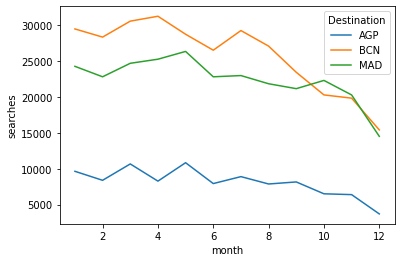

In [186]:
sns.lineplot(x=destination_searches_total["month"], 
             y=destination_searches_total["searches"], 
             hue=destination_searches_total["Destination"]);

# Exercise 4
#### For every search in the searches file, find out whether the search ended up in a booking or not (using the info in the bookings file). For instance, search and booking origin and destination should match. 

In [187]:
# Define path to CSV files
bookings_file = "/Users/je637620/Desktop/challenge/bookings.csv"
searches_file = "/Users/je637620/Desktop/challenge/searches.csv"

In [188]:
# Import required modules
import pandas as pd

In [189]:
# Inspect data in one chunk
pd.set_option("display.max_columns", None)
df = pd.read_csv(searches_file, sep="^",  iterator=True, chunksize=10000)
for chunk in df:
    print(chunk.columns.to_list())
    print(chunk.dtypes)
    break

['Date', 'Time', 'TxnCode', 'OfficeID', 'Country', 'Origin', 'Destination', 'RoundTrip', 'NbSegments', 'Seg1Departure', 'Seg1Arrival', 'Seg1Date', 'Seg1Carrier', 'Seg1BookingCode', 'Seg2Departure', 'Seg2Arrival', 'Seg2Date', 'Seg2Carrier', 'Seg2BookingCode', 'Seg3Departure', 'Seg3Arrival', 'Seg3Date', 'Seg3Carrier', 'Seg3BookingCode', 'Seg4Departure', 'Seg4Arrival', 'Seg4Date', 'Seg4Carrier', 'Seg4BookingCode', 'Seg5Departure', 'Seg5Arrival', 'Seg5Date', 'Seg5Carrier', 'Seg5BookingCode', 'Seg6Departure', 'Seg6Arrival', 'Seg6Date', 'Seg6Carrier', 'Seg6BookingCode', 'From', 'IsPublishedForNeg', 'IsFromInternet', 'IsFromVista', 'TerminalID', 'InternetOffice']
Date                 object
Time                 object
TxnCode              object
OfficeID             object
Country              object
Origin               object
Destination          object
RoundTrip             int64
NbSegments            int64
Seg1Departure        object
Seg1Arrival          object
Seg1Date             object

In [190]:
# Inspect data in one chunk
pd.set_option("display.max_columns", None)
df = pd.read_csv(bookings_file, sep="^",  iterator=True, chunksize=10000)
for chunk in df:
    print(chunk.columns.to_list())
    print(chunk.dtypes)
    break

['act_date           ', 'source', 'pos_ctry', 'pos_iata', 'pos_oid  ', 'rloc          ', 'cre_date           ', 'duration', 'distance', 'dep_port', 'dep_city', 'dep_ctry', 'arr_port', 'arr_city', 'arr_ctry', 'lst_port', 'lst_city', 'lst_ctry', 'brd_port', 'brd_city', 'brd_ctry', 'off_port', 'off_city', 'off_ctry', 'mkt_port', 'mkt_city', 'mkt_ctry', 'intl', 'route          ', 'carrier', 'bkg_class', 'cab_class', 'brd_time           ', 'off_time           ', 'pax', 'year', 'month', 'oid      ']
act_date               object
source                 object
pos_ctry               object
pos_iata               object
pos_oid                object
rloc                   object
cre_date               object
duration                int64
distance                int64
dep_port               object
dep_city               object
dep_ctry               object
arr_port               object
arr_city               object
arr_ctry               object
lst_port               object
lst_city             

In [191]:
# Functions
def normalize_date(date):
        try:
            datetime.strptime(date.strip(), '%Y-%m-%d')
            return date
        except Exception as e:
            return ""
# Functions
def normalize_datetime(date):
        try:
            date = datetime.strptime(date.strip(), '%Y-%m-%d %H:%M:%S')
            return date.strftime("%Y-%m-%d")
        except Exception as e:
            return ""

# remove duplicates
def remove_duplicates(file, newfile):
    df = pd.read_csv(file, sep="^", iterator=True, chunksize=1000000, low_memory=False, dtype=str)
    all_chunks = pd.DataFrame()
    # Iterate chunks to remove duplicates
    for index, chunk in enumerate(df):
        chunk.columns = chunk.columns.str.strip()
        for column in chunk.columns:
            chunk[column] = chunk[column].str.strip()
        all_chunks = all_chunks.append(chunk)
        all_chunks.drop_duplicates(inplace=True)
    all_chunks.to_csv(newfile, sep="^", index=False)

In [100]:
# remove duplicates from searches
searches_file_no_dup = "/Users/je637620/Desktop/challenge/searches_no_dup.csv"
!wc -l {searches_file}
remove_duplicates(searches_file, searches_file_no_dup)
!wc -l {searches_file_no_dup}

 20390198 /Users/je637620/Desktop/challenge/searches.csv
  359005 /Users/je637620/Desktop/challenge/searches_no_dup.csv


In [192]:
# remove duplicates from bookings
bookings_file_no_dup = "/Users/je637620/Desktop/challenge/bookings_no_dup.csv"
!wc -l {bookings_file}
remove_duplicates(bookings_file, bookings_file_no_dup)
!wc -l {bookings_file_no_dup}

 10000011 /Users/je637620/Desktop/challenge/bookings.csv
 1000004 /Users/je637620/Desktop/challenge/bookings_no_dup.csv


In [193]:
# read csv file using chunks. Restrict to columns of interest
df = pd.read_csv(bookings_file_no_dup, sep="^", usecols=["dep_port", "arr_port", "brd_time", "pax"], iterator=True, chunksize=100000)

# created to control number of chunks to process for debugging
current_chunk = 1
max_chunks = -1

# Dataframes to concat partial results
total_bookings = None
    
# Iterate every chunk
for chunk in df:

    # Clean data filling nan with 0 and removing null values on top
    chunk = chunk[(chunk["dep_port"].notnull()) & (chunk["arr_port"].notnull()) & (chunk["brd_time"].notnull())]
    chunk["brd_time"] = chunk["brd_time"].apply(normalize_datetime)
    chunk = chunk.rename(columns={"dep_port": "Origin", "arr_port": "Destination", "brd_time": "Dpt_Date"})
    
    # Filter data to valid dates after normalization
    chunk = chunk[chunk["Dpt_Date"] != ""]

    # Normalize Destination codes
    chunk["Origin"] = chunk["Origin"].str.strip().str.upper()
    chunk["Destination"] = chunk["Destination"].str.strip().str.upper()
    
    partial_bookings = chunk.groupby(by=["Origin", "Destination", "Dpt_Date"])["pax"].sum()
        
    total_bookings = pd.concat([total_bookings, partial_bookings])
        
    if current_chunk > 0 and current_chunk == max_chunks:
        break
    current_chunk += 1
    
total_bookings = total_bookings.groupby(by=["Origin", "Destination", "Dpt_Date"]).sum()
total_bookings = total_bookings.reset_index()
total_bookings.rename(columns={total_bookings.columns[3]: "Bookings"}, inplace = True)
total_bookings = total_bookings.drop_duplicates(keep='first')
total_bookings.head()

,Origin,Destination,Dpt_Date,Bookings
0,AAB,ROV,2013-05-30,2.0
1,AAB,ROV,2013-08-27,18.0
2,AAE,ALG,2013-01-13,1.0
3,AAE,ALG,2013-01-14,1.0
4,AAE,ALG,2013-01-17,1.0


In [194]:
# read csv file using chunks. Restrict to columns of interest
df = pd.read_csv(searches_file_no_dup, sep="^", usecols=["Origin", "Destination", "Seg1Date"], iterator=True, chunksize=100000)

# created to control number of chunks to process for debugging
current_chunk = 1
max_chunks = -1

# Dataframes to concat partial results
total_searches = None

# Iterate every chunk
for chunk in df:

    # Clean data filling nan with 0 and removing null values on top
    chunk = chunk[(chunk["Origin"].notnull()) & (chunk["Destination"].notnull()) & (chunk["Seg1Date"].notnull())]
    chunk["Seg1Date"] = chunk["Seg1Date"].apply(normalize_date)
    chunk = chunk.rename(columns={"Seg1Date": "Dpt_Date"})
    
    # Filter data to valid dates after normalization
    chunk = chunk[chunk["Dpt_Date"] != ""]
        
    # Normalize Destination codes
    chunk["Origin"] = chunk["Origin"].str.strip().str.upper()
    chunk["Destination"] = chunk["Destination"].str.strip().str.upper()
    
    partial_searches = chunk[["Origin", "Destination", "Dpt_Date"]].groupby(by=["Origin", "Destination", "Dpt_Date"]).size()
    
    total_searches = pd.concat([total_searches, partial_searches])

    if current_chunk > 0 and current_chunk == max_chunks:
        break
    current_chunk += 1
        
total_searches = total_searches.groupby(by=["Origin", "Destination", "Dpt_Date"]).sum()
total_searches = total_searches.reset_index()
total_searches.rename(columns={total_searches.columns[3]: "Searches" }, inplace = True)
total_searches.head()

,Origin,Destination,Dpt_Date,Searches
0,AAC,CAI,2013-02-28,1
1,AAE,ALG,2013-06-21,1
2,AAE,MRS,2013-06-05,1
3,AAE,NCE,2013-08-29,1
4,AAE,ORY,2013-12-26,1


In [195]:
# We can see there are flights with number of bookings < 1. Means cancellations?
total_bookings[total_bookings["Bookings"] < 0].head()

,Origin,Destination,Dpt_Date,Bookings
22,AAE,ALG,2013-05-04,-1.0
23,AAE,ALG,2013-05-11,-1.0
24,AAE,ALG,2013-05-13,-1.0
68,AAE,ORN,2013-10-07,-3.0
87,AAL,AKL,2014-06-14,-5.0


In [196]:
# Remove bookings with negative Bookings because make no sense
total_bookings = total_bookings[total_bookings["Bookings"] >= 0]

In [197]:
# Left join of search and booking considering booking brd_time (normalized as Dpt_date) matches search Seg1Date (normalized as Dpt_date)
# Seg1Date: day to start the route
# brd_time: day of boarding
# Concern: delay on the airport might cause a flight to board next day if planned boarding time is closed to midnight
s_b = total_searches.merge(total_bookings, how="left")
s_b["Bookings"].fillna(value=0, inplace=True)
s_b["Searches"].fillna(value=0, inplace=True)
s_b = s_b.astype({'Bookings': 'int64', 'Searches': 'int64'})
s_b.head()

,Origin,Destination,Dpt_Date,Searches,Bookings
0,AAC,CAI,2013-02-28,1,0
1,AAE,ALG,2013-06-21,1,0
2,AAE,MRS,2013-06-05,1,0
3,AAE,NCE,2013-08-29,1,0
4,AAE,ORY,2013-12-26,1,0


In [198]:
# We cannot know if a specific search became a booking
# Example: We have flights with more Searches than Bookings. There is no way to conclude which searches became a booking
print(s_b[(s_b["Searches"] > s_b["Bookings"]) & (s_b["Bookings"] > 0)].head())
# Example: We have flights with more Bookings than Bookings. There is no way to conclude a booking was originated in a search (other channels?)
print(s_b[(s_b["Searches"] < s_b["Bookings"]) & (s_b["Bookings"] > 0)].head())

     Origin Destination    Dpt_Date  Searches  Bookings
3000    AGP         PMI  2013-03-15         2         1
3398    AHB         JED  2013-01-24         2         1
3540    AHB         RUH  2013-02-06         2         1
3568    AHB         RUH  2013-04-03         3         1
3596    AHB         RUH  2013-06-23         4         1
    Origin Destination    Dpt_Date  Searches  Bookings
44     AAL         CPH  2013-01-16         1         4
51     AAL         CPH  2013-05-15         1         2
158    AAQ         DME  2013-08-03         1         4
530    ABQ         PVR  2014-01-18         1         2
819    ABZ         LHR  2013-12-13         1         3


In [199]:
# Keep only flights with searches and bookings
s_b = s_b[(s_b["Searches"] > 0) & (s_b["Bookings"] > 0)]
s_b.head()

,Origin,Destination,Dpt_Date,Searches,Bookings
44,AAL,CPH,2013-01-16,1,4
51,AAL,CPH,2013-05-15,1,2
52,AAL,CPH,2013-05-22,1,1
158,AAQ,DME,2013-08-03,1,4
530,ABQ,PVR,2014-01-18,1,2


In [200]:
# Let's consider the balance between number of searches and number of bookings for a flight with the concerns above 
import numpy as np
s_b["Searches_in_Bookings"] = np.minimum(s_b["Searches"], s_b["Bookings"])
print(f"Total searches that finish in bookings: {np.sum(s_b['Searches_in_Bookings'])}")

Total searches that finish in bookings: 11799


In [201]:
# Save searches as origin, destination, date, but we cannot include txncode because it is not possible
searches_in_bookings_file = "/Users/je637620/Desktop/challenge/searches_in_bookings.csv"
s_b.to_csv(searches_in_bookings_file, sep="^", index=False)

# Exercise 5
#### Wrap the output of the second exercise in a web service that returns the data in JSON format

#### The web service should accept a parameter n>0. For the top 10 airports, n is 10. For the X top airports, n is X 

In [25]:
# See exercise5.py